In [1]:
import maboss
import numpy as np
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
sim = maboss.load("cellcycle.bnd", "cellcycle_runcfg.cfg")

Here we need two settings to activate the individual trajectories output : 
- display_traj = 1
- thread_count = 1 (export is not working in multi-thread mode)

And we choose a discrete time, as this analysis doesn't care about time, and max_time (which is the number of time ticks in discrete time) equal to 1000

In [3]:
sim_trajs = sim.copy()

sim_trajs.param["display_traj"] = 1
sim_trajs.param["thread_count"] = 1

sim_trajs.param["discrete_time"] = 1
sim_trajs.param["max_time"] = 1000
sim_trajs.param["time_tick"] = 1

In [4]:
%time res_trajs = sim_trajs.run(workdir="sim_trajectories")

CPU times: user 22.5 ms, sys: 11 ms, total: 33.5 ms
Wall time: 9min 58s


Now we need to load the individual trajectories, as this is not implemented in pyMaBoSS yet

Note that the individual trajectories print all nodes, so here we set an output list to remove the other nodes

In [5]:
trajs = []
outputs =["CycA", "CycB", "CycE"]
all_states = set()
with open(res_trajs._path + "/res_traj.txt", "r") as res_traj:
    id_trajectory = 0
    states = []
    for line in res_traj.readlines():
            if line.startswith("Trajectory"):
                if id_trajectory > 0:
                    trajs.append(states)
                    states = []
                id_trajectory = int(line.split("#")[1])
                
            elif line.startswith(" istate"):
                state = line.split("\t")[1].strip()
                state_array = " -- ".join(sorted([node for node in state.split(" -- ") if node in outputs]))
                if state_array == '':
                    state_array = "<nil>"
                    
                all_states.add(state_array)
                states.append(state_array)
                
            elif line == "\n":
                pass
            
            else:
#                 print(line.split("\t"))
                state = line.split("\t")[1].strip()
                state_array = " -- ".join(sorted([node for node in state.split(" -- ") if node in outputs]))
                
                if state_array == '':
                    state_array = "<nil>"
                
                
                if (len(states) == 0 or states[len(states)-1] != state_array):
                    all_states.add(state_array)                    
                    states.append(state_array)

We obtain the sequence of states in each trajectory (a list of lists)

Here, we build the STG, and compute its observed probabilities

In [7]:
state_ids = {state:ind for ind, state in enumerate(sorted(list(all_states))) }

In [8]:
stg_counts = np.zeros((len(all_states), len(all_states)))
for i, t_traj in enumerate(trajs):
    for j, t_state in enumerate(t_traj):
        if j > 0:
            stg_counts[state_ids[t_traj[j-1]], state_ids[t_state]] += 1

In [9]:
data = pd.DataFrame(
    data=np.divide(stg_counts,stg_counts.sum(axis=0)[:, np.newaxis]), 
    index=state_ids.keys(), columns=state_ids.keys()
)
data

,<nil>,CycA,CycA -- CycB,CycA -- CycB -- CycE,CycA -- CycE,CycB,CycB -- CycE,CycE
<nil>,0.000000,0.486806,0.000000,0.000000,0.000000,0.015383,0.000000,0.507181
CycA,0.234893,0.000000,0.736210,0.000000,0.026787,0.000000,0.000000,0.000000
CycA -- CycB,0.000000,0.497967,0.000000,0.001376,0.000000,0.498065,0.000000,0.000000
CycA -- CycB -- CycE,0.000000,0.000000,0.904727,0.000000,0.046814,0.000000,0.047110,0.000000
CycA -- CycE,0.000000,0.883336,0.000000,0.111279,0.000000,0.000000,0.000000,0.002056
CycB,0.998151,0.000000,0.000210,0.000000,0.000000,0.000000,0.000254,0.000000
CycB -- CycE,0.000000,0.000000,0.000000,0.007508,0.000000,0.468143,0.000000,0.522814
CycE,0.003796,0.000000,0.000000,0.000000,0.995702,0.000000,0.000402,0.000000


And we plot it as a graph

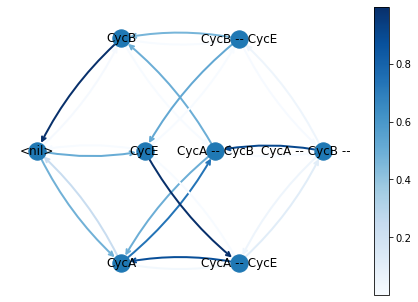

In [10]:
G = nx.from_pandas_adjacency(data,  create_using=nx.DiGraph())

edge_colors = [edge['weight'] for _, edge in G.edges.items()]

pos = graphviz_layout(G, prog="sfdp")
nx.draw(G, pos, with_labels=True, edgelist=[])

edges = nx.draw_networkx_edges(
    G,
    pos,
    arrowstyle="->",
    arrowsize=10,
    edgelist=G.edges().keys(),
    edge_color=edge_colors,
    edge_cmap=plt.cm.Blues,
    width=2,
    connectionstyle='arc3, rad = 0.1'
)

pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
pc.set_array(edge_colors)
plt.colorbar(pc)
plt.show()